<a href="https://colab.research.google.com/github/zctpig/Caltech-UCSD-Birds-200-2011/blob/master/%E2%80%9C%E2%80%9Cpytorch_caltech_birds_classification_ipynb%E2%80%9D%E7%9A%84%E5%89%AF%E6%9C%AC%E2%80%9D%E7%9A%84%E5%89%AF%E6%9C%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Train Test Split

In [0]:
!pip install scikit-image==0.14.3

In [0]:
import skimage
print(skimage.__version__)

In [0]:
!wget --no-check-certificate \
    http://www.vision.caltech.edu/visipedia-data/CUB-200-2011/CUB_200_2011.tgz \
    -O /tmp/cats_and_dogs_filtered.zip

In [0]:
!tar -zxf /tmp/cats_and_dogs_filtered.zip -C /tmp/

In [0]:
PATH = '/tmp/CUB_200_2011/'

In [0]:
read_line = open(PATH + 'train_test_split.txt')

In [0]:
a = read_line.readlines()

In [0]:
a[0].split(' ')[1].split('\n')[0]

In [0]:

classes = open(PATH + 'classes.txt')
c_names = classes.readlines()
len(c_names)

In [0]:
for i in range(len(c_names)):
    c_names[i] = c_names[i].split(' ')[1]

In [0]:
c_names[0].split('\n')[0]

In [0]:
import os
for i in range(len(c_names)):
    dir_name = PATH + 'test/' + c_names[i].split('\n')[0]
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)

In [0]:
for i in range(len(c_names)):
    dir_name = PATH + 'train/' + c_names[i].split('\n')[0]
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)

In [0]:
import torch
from torch import nn, optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
import torch.utils.data as data
from torchvision import datasets, models, transforms

In [0]:
train_dataset = datasets.ImageFolder(PATH + 'images')

In [0]:
from skimage import io

In [0]:
print(len(train_dataset.imgs))

In [0]:
for j in range(len(train_dataset.imgs)):
    if(a[j].split(' ')[1].split('\n')[0] == '0'):
        path = train_dataset.imgs[j][0]
        img = io.imread(path)
        folder = train_dataset.imgs[j][0][9:].split('/')[-2]
        img_name = train_dataset.imgs[j][0][9:].split('/')[-1]
        io.imsave(PATH + 'test/' + folder + '/' + img_name, img)
        os.remove(path)
    else:
        path = train_dataset.imgs[j][0]
        img = io.imread(path)
        folder = train_dataset.imgs[j][0][9:].split('/')[-2]
        img_name = train_dataset.imgs[j][0][9:].split('/')[-1]
        io.imsave(PATH + 'train/' + folder + '/' + img_name, img)
        os.remove(path)

In [0]:
total = 0
for path, dirs, files in os.walk(PATH + 'train'):
    total += len(files)
print('train images number:', total)

In [0]:
total = 0
for path, dirs, files in os.walk(PATH + 'test'):
    total += len(files)
print('test images number:', total)

# Model

In [0]:
# here are the necessary imports
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import seaborn as sns
plt.ion()

In [0]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        #transforms.RandomRotation(45),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


# loading datasets with PyTorch ImageFolder
image_datasets = {x: datasets.ImageFolder(os.path.join(PATH, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}
# defining data loaders to load data using image_datasets and transforms, here we also specify batch size for the mini batch
dataloders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()

In [0]:
dataset_sizes

In [0]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [0]:
from google.colab import drive
drive.mount('/gdrive')

In [0]:
G_DRIVE = '/gdrive/My Drive/'

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        
        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                print(scheduler.get_lr())
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.item()
                running_corrects += torch.sum(preds == labels.data).item()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
                state = {'model':model_ft.state_dict(),'optim':optimizer_ft.state_dict()}
                torch.save(state, G_DRIVE + 'point_resnet_best.pth')
            
            if phase == 'train':
                scheduler.step()

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best test Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [0]:
def visualize_model(model, num_images=8):
    images_so_far = 0
    fig = plt.figure()
    

    for i, data in enumerate(dataloders['test']):
        inputs, labels = data
        #print(labels)
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)
        #print(labels)
        #_, lab = torch.max(labels.data, 1)
        outputs = model(inputs)
        #print(outputs)
        _, preds = torch.max(outputs.data, 1)
        #print(preds)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('class: {} predicted: {}'.format(class_names[labels.data[j]], class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

In [0]:
model_ft = models.resnet50(pretrained=True) # loading a pre-trained(trained on image net) resnet18 model from torchvision models
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 200)      # changing the last layer for this dataset by setting last layer neurons to 200 as this dataset has 200 categories
 
if use_gpu:                                 # if gpu is available then use it
    model_ft = model_ft.cuda()       
# model_ft = model_ft.float()
criterion = nn.CrossEntropyLoss()           # defining loss function

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)
# optimizer_ft = optim.Adam(model_ft.parameters())

In [0]:
if os.path.exists(G_DRIVE + 'point_resnet_best.pth'):
    checkpoint = torch.load(G_DRIVE + 'point_resnet_best.pth')
    model_ft.load_state_dict(checkpoint['model'])
    optimizer_ft.load_state_dict(checkpoint['optim'])

In [0]:
scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, 30, gamma=0.1, last_epoch=-1)

In [40]:
model_ft = train_model(model_ft, criterion, optimizer_ft, scheduler, num_epochs=90)

Epoch 0/89
----------
[0.01]
train Loss: 0.2760 Acc: 0.0949
test Loss: 0.2055 Acc: 0.2254

Epoch 1/89
----------
[0.01]
train Loss: 0.2098 Acc: 0.2114
test Loss: 0.1820 Acc: 0.2974

Epoch 2/89
----------
[0.01]
train Loss: 0.1832 Acc: 0.2860
test Loss: 0.1637 Acc: 0.3707

Epoch 3/89
----------
[0.01]
train Loss: 0.1615 Acc: 0.3490
test Loss: 0.1358 Acc: 0.4411

Epoch 4/89
----------
[0.01]
train Loss: 0.1457 Acc: 0.4014
test Loss: 0.1376 Acc: 0.4651

Epoch 5/89
----------
[0.01]
train Loss: 0.1363 Acc: 0.4476
test Loss: 0.1069 Acc: 0.5433

Epoch 6/89
----------
[0.01]
train Loss: 0.1247 Acc: 0.4962
test Loss: 0.1240 Acc: 0.5176

Epoch 7/89
----------
[0.01]
train Loss: 0.1207 Acc: 0.5025
test Loss: 0.1040 Acc: 0.5713

Epoch 8/89
----------
[0.01]
train Loss: 0.1135 Acc: 0.5282
test Loss: 0.0989 Acc: 0.5908

Epoch 9/89
----------
[0.01]
train Loss: 0.1070 Acc: 0.5601
test Loss: 0.0959 Acc: 0.5939

Epoch 10/89
----------
[0.01]
train Loss: 0.0998 Acc: 0.5762
test Loss: 0.0962 Acc: 0.6162

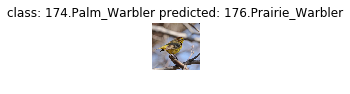

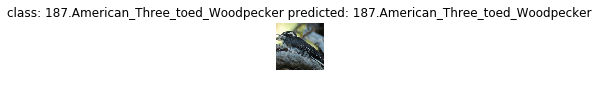

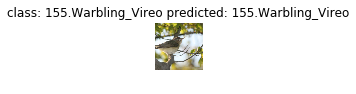

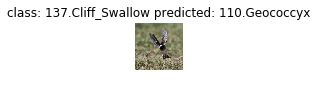

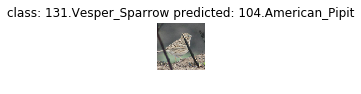

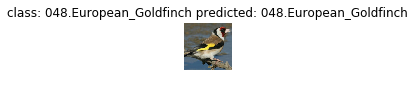

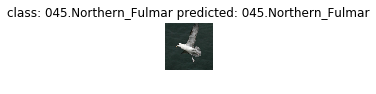

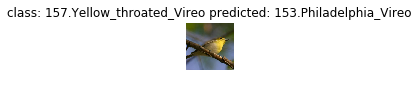

In [41]:
visualize_model(model_ft)

In [0]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [0]:
def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    #with torch.no_grad():
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [0]:
def calc_accuracy(model, data):
    model.eval()
    if use_gpu:
        model.cuda()    
    
    top1 = AverageMeter()
    top5 = AverageMeter()
    
    for idx, (inputs, labels) in enumerate(dataloders[data]):
        if use_gpu:
            inputs, labels = inputs.cuda(), labels.cuda()
        # obtain the outputs from the model
        outputs = model.forward(Variable(inputs))
        prec1, prec5 = accuracy(outputs, Variable(labels), topk=(1, 5))
        top1.update(prec1[0], inputs.size(0))
        top5.update(prec5[0], inputs.size(0))
        
    return top1 ,top5
    
top1 ,top5 = calc_accuracy(model_ft, 'test')

In [45]:
top1.avg

tensor(76.9762, device='cuda:0')

In [46]:
top5.avg

tensor(93.8385, device='cuda:0')